# Overall

## Data Collection
### Source 
1. Crawl All the text content from 'https://www.plusonefoundation.org/'
2. Documentation (PDF, DOC, TXT...)
### What to improve
1. Improve the quality of the data (for demo, I collected all character)
2. Using nonstructual Database ( MongoDB...)
3. There may be some Dynamic content on the website( using some webdriver to crawl them)
4. Split the sources for different visiter
    1. people need help
    2. want to donate
    3. Support Different Language
    4. ...
5. ...

## RAG and Developing 

In [ ]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
import time
import random
import os

# Save all downloaded or crawled content to the folder 'URL'
folder = 'URL'
if not os.path.exists(folder):
    os.makedirs(folder)

# Set the starting URL and corresponding domain
start_url = 'https://www.plusonefoundation.org/'
domain = urlparse(start_url).netloc

# Record visited URLs to avoid duplicate crawling
visited = set()

def sanitize_filename(url):
    """
    Generate a safe file name based on the URL:
      - Combine the domain and path,
      - Replace '/' with '_' to avoid directory issues,
      - Append the ".txt" extension.
    """
    parsed = urlparse(url)
    filename = parsed.netloc + parsed.path
    if filename.endswith('/'):
        filename = filename[:-1]
    filename = filename.replace('/', '_')
    if not filename:
        filename = 'index'
    return filename + ".txt"

def download_attachment(url):
    """
    If the URL points to a PDF or DOCX file, download it in binary mode
    and save it using its original extension.
    """
    try:
        response = requests.get(url, timeout=10)
    except Exception as e:
        print(f"Error accessing {url}: {e}")
        return

    if response.status_code != 200:
        print(f"Failed to download attachment {url}, status code: {response.status_code}")
        return

    parsed = urlparse(url)
    filename = os.path.basename(parsed.path)
    if not filename:
        print(f"Unable to obtain a valid filename from {url}")
        return

    filepath = os.path.join(folder, filename)
    try:
        with open(filepath, "wb") as f:
            f.write(response.content)
        print(f"Downloaded attachment {url} to {filepath}")
    except Exception as e:
        print(f"Error writing attachment file {filepath}: {e}")

def crawl(url):
    if url in visited:
        return
    visited.add(url)
    
    ext = os.path.splitext(urlparse(url).path)[1].lower()
    # If the current URL points to a PDF or DOCX, download it directly and end this branch
    if ext in [".pdf", ".docx"]:
        download_attachment(url)
        return

    try:
        response = requests.get(url, timeout=10)
    except Exception as e:
        print(f"Error accessing {url}: {e}")
        return

    # Handle rate limiting
    if response.status_code == 429:
        print(f"Access to {url} denied (status code: 429), waiting before retrying...")
        time.sleep(60)
        return crawl(url)

    if response.status_code != 200:
        print(f"Failed to access {url}, status code: {response.status_code}")
        return

    soup = BeautifulSoup(response.content, 'html.parser')
    text_content = soup.get_text(separator=' ', strip=True)
    
    # Generate a safe file name and save the page text content
    filename = sanitize_filename(url)
    filepath = os.path.join(folder, filename)
    try:
        with open(filepath, 'w', encoding='utf-8') as f:
            f.write(text_content)
        print(f"Saved {url} to {filepath}")
    except Exception as e:
        print(f"Error writing file {filepath}: {e}")

    # Traverse all links on the page
    for link in soup.find_all('a', href=True):
        full_url = urljoin(url, link['href'])
        # Skip if the URL has already been processed
        if full_url in visited:
            continue
        # If the link points to a PDF or DOCX, download the attachment
        ext = os.path.splitext(urlparse(full_url).path)[1].lower()
        if ext in [".pdf", ".docx"]:
            download_attachment(full_url)
            continue

        # Only crawl URLs within the same domain
        if urlparse(full_url).netloc == domain:
            time.sleep(random.uniform(3, 8))  # Randomly rest for 3-8 seconds to slow down crawling
            crawl(full_url)

# Start crawling
crawl(start_url)
print("Crawling complete!")

In [ ]:
def fix_pdf_downloads():
    """
    For files with the pattern '*.pdf.txt' or '*.docx.txt' in the URL folder,
    reconstruct the original URL and download the file directly.
    Sleep for 5 seconds after processing each file.
    """
    for file in os.listdir(folder):
        if file.endswith(".pdf.txt") or file.endswith(".docx.txt"):
            # Determine the file type and remove the '.txt' extension
            if file.endswith(".pdf.txt"):
                file_type = "PDF"
                base_filename = file[:-4]  # e.g. "www.plusonefoundation.org_s_Impact.pdf"
            else:
                file_type = "DOCX"
                base_filename = file[:-4]  # e.g. "www.plusonefoundation.org_s_Example.docx"

            # Attempt to reconstruct the original URL.
            # The sanitized filename was generated as: domain + path, with '/' replaced by '_'.
            # We assume the first '_' separates the domain from the path.
            underscore_index = base_filename.find('_')
            if underscore_index == -1:
                print(f"Cannot determine URL for {file}: missing '_' separator.")
                continue
            domain_part = base_filename[:underscore_index]
            path_fragment = base_filename[underscore_index+1:]
            # Convert underscores in the path fragment back to '/' and add a leading '/'.
            original_path = "/" + path_fragment.replace('_', '/')
            original_url = "https://" + domain_part + original_path
            
            print(f"Re-downloading {file_type} from {original_url}")
            try:
                response = requests.get(original_url, timeout=10)
            except Exception as e:
                print(f"Error accessing {original_url}: {e}")
                continue
            
            if response.status_code != 200:
                print(f"Failed to download {file_type} from {original_url}, status code: {response.status_code}")
                continue
                
            # Set the file path (dropping the extra '.txt' so the extension remains '.pdf' or '.docx')
            file_filepath = os.path.join(folder, base_filename)
            try:
                with open(file_filepath, "wb") as f:
                    f.write(response.content)
                print(f"Downloaded {file_type} from {original_url} to {file_filepath}")
            except Exception as e:
                print(f"Error writing {file_type} file {file_filepath}: {e}")
            
            # Sleep for 5 seconds after processing each file
            time.sleep(5)

# To run the fix function, simply call:
fix_pdf_downloads()

In [4]:
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Pinecone
from pinecone import Pinecone, ServerlessSpec
from tqdm.notebook import tqdm
import langchain
import openai
from openai import OpenAI
import string
import pandas as pd
import matplotlib.pyplot as plt

Processing file: www.plusonefoundation.org_readnow_huskiesforneuodiversityandplusonepenpals.txt
Reconstructed URL: https://www.plusonefoundation.org/readnow/huskiesforneuodiversityandplusonepenpals
File processed: www.plusonefoundation.org_readnow_huskiesforneuodiversityandplusonepenpals.txt -> 2 chunks. (1/180)
Processing file: www.plusonefoundation.org_readnow_2018_5_8_i-tried-bullet-journaling-a-popular-creative-outlet.txt
Reconstructed URL: https://www.plusonefoundation.org/readnow/2018/5/8/i-tried-bullet-journaling-a-popular-creative-outlet
File processed: www.plusonefoundation.org_readnow_2018_5_8_i-tried-bullet-journaling-a-popular-creative-outlet.txt -> 3 chunks. (2/180)
Processing file: www.plusonefoundation.org_cerebrovascular-disease.txt
Reconstructed URL: https://www.plusonefoundation.org/cerebrovascular-disease
File processed: www.plusonefoundation.org_cerebrovascular-disease.txt -> 2 chunks. (3/180)
Processing file: www.plusonefoundation.org_readnow_2024_2_20_world-enceph

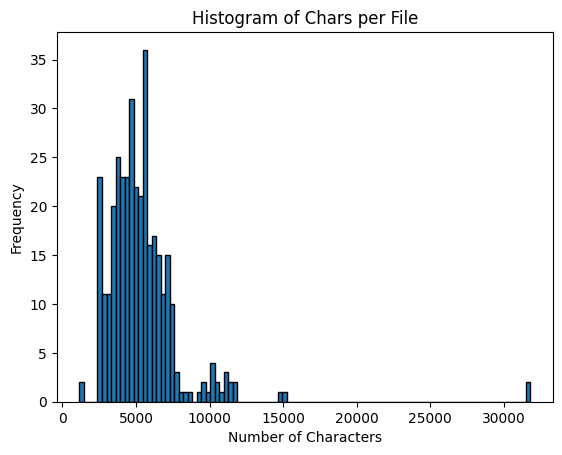

URL: https://www.plusonefoundation.org/readnow/huskiesforneuodiversityandplusonepenpals
Number of chunks: 2

URL: https://www.plusonefoundation.org/readnow/2018/5/8/i-tried-bullet-journaling-a-popular-creative-outlet
Number of chunks: 3

URL: https://www.plusonefoundation.org/cerebrovascular-disease
Number of chunks: 2

URL: https://www.plusonefoundation.org/readnow/2024/2/20/world-encephalitis-day-1
Number of chunks: 3

URL: https://www.plusonefoundation.org/neuro-disorders
Number of chunks: 2

URL: https://www.plusonefoundation.org/2025tbi
Number of chunks: 2

URL: https://www.plusonefoundation.org/readnow/2018/3/17/the-secret-to-seasonal-sadness
Number of chunks: 3

URL: https://www.plusonefoundation.org/readnow/2021/1/24/a-gallery-of-fleeting-moments-and-memories-ywceh
Number of chunks: 3

URL: https://www.plusonefoundation.org/readnow/2021/2/16/live-more-positively-and-inspire-others
Number of chunks: 3

URL: https://www.plusonefoundation.org/understanding-autism-spectrum-disorder

In [11]:
import os
import time
import sys
import hashlib
import matplotlib.pyplot as plt
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyMuPDFLoader

# Folder that contains the files
folder = 'URL'

# Initialize the text splitter
CHUNK_OVERLAP = 50
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2500,
    chunk_overlap=CHUNK_OVERLAP,
    length_function=len,
    is_separator_regex=False,
)

def filename_to_url(filename):
    """
    Convert a sanitized filename back to an original URL.
    The original filename was generated as: domain + path with "/" replaced by "_",
    then appended with the extension (e.g. ".txt", ".pdf", or ".docx").
    """
    if filename.endswith(".txt"):
        base = filename[:-4]
    elif filename.endswith(".pdf"):
        base = filename[:-4]
    elif filename.endswith(".docx"):
        base = filename[:-5]
    else:
        base = filename

    underscore_index = base.find('_')
    if underscore_index == -1:
        return "https://" + base
    domain_part = base[:underscore_index]
    path_fragment = base[underscore_index+1:]
    original_path = "/" + path_fragment.replace('_', '/')
    original_url = "https://" + domain_part + original_path
    return original_url

# Dictionary mapping original URL to its list of text chunks
url_chunks_mapping = {}

# Process each eligible file in the folder
files = os.listdir(folder)
total_files = len([f for f in files if f.endswith((".txt", ".pdf", ".docx"))])
processed = 0

for file in files:
    if not (file.endswith(".txt") or file.endswith(".pdf") or file.endswith(".docx")):
        continue

    print(f"Processing file: {file}", flush=True)
    file_path = os.path.join(folder, file)
    text = ""
    if file.endswith(".txt"):
        with open(file_path, "r", encoding="utf-8") as f:
            text = f.read()
    elif file.endswith(".pdf"):
        loader = PyMuPDFLoader(file_path)
        document = loader.load()
        text = " ".join([page.page_content for page in document])
    elif file.endswith(".docx"):
        import docx
        doc = docx.Document(file_path)
        paragraphs = [para.text for para in doc.paragraphs if para.text.strip()]
        text = "\n".join(paragraphs)
    
    # 记录文件字符数（可选）
    file_char_lengths.append(len(text))
    
    # 直接将文件名转换成原始 URL，并用作字典的键
    original_url = filename_to_url(file)
    print(f"Reconstructed URL: {original_url}", flush=True)
    
    # 分块文本
    chunks = text_splitter.split_text(text)
    url_chunks_mapping[original_url] = chunks

    processed += 1
    print(f"File processed: {file} -> {len(chunks)} chunks. ({processed}/{total_files})", flush=True)

# 绘制直方图（统计每个文件的字符数）
plt.hist(file_char_lengths, bins=100, edgecolor='black')
plt.title('Histogram of Chars per File')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

# 输出每个 URL 对应的分块数量
for url, chunks in url_chunks_mapping.items():
    print(f"URL: {url}")
    print(f"Number of chunks: {len(chunks)}\n")

In [15]:
import os
import json
import pandas as pd
import string
from tqdm import tqdm
from openai import OpenAI

# load the OpenAI API key from a file
openai_key = 'OPEN_AI_API_KEY'
if os.path.exists('open_ai_key.txt'):
    with open('open_ai_key.txt', 'r') as f:
        openai_key = f.read().strip()
client = OpenAI(api_key=openai_key)

In [ ]:
pineconeKey = 'PINECONE_API_KEY'
if os.path.exists('PlusOne.txt'):
    with open('PlusOne.txt', 'r') as f:
        pineconeKey = f.read().strip()
pc = Pinecone(api_key=pineconeKey)
index = pc.Index("plusone")
index_name = "plusone"

# pc.create_index(
#     name=index_name,
#     dimension=1536, # Replace with your model dimensions
#     metric="cosine", # Replace with your model metric
#     spec=ServerlessSpec(
#         cloud="aws",
#         region="us-east-1"
#     ) 
# )

In [19]:
# Function to get embeddings using the OpenAI text-embedding-3-small model
def get_embedding(text, model="text-embedding-3-small"):
    # Replace newline characters to form a single line
    text = text.replace("\n", " ")
    return client.embeddings.create(input=[text], model=model).data[0].embedding

# Set CSV file path for storing URL, chunk, and embedding mapping
csv_file = 'url_chunk_embedding_mapping.csv'

# Check if CSV already exists; if not, generate embeddings for each chunk from url_chunks_mapping
if os.path.exists(csv_file):
    df = pd.read_csv(csv_file)
else:
    rows = []
    # Iterate through the url_chunks_mapping dictionary
    # (url_chunks_mapping is assumed to be defined already)
    for url, chunks in tqdm(url_chunks_mapping.items(), desc="Processing URL-Chunks"):
        for chunk in chunks:
            # Preprocess the chunk by removing punctuation and newlines
            clean_text = chunk.translate(str.maketrans('', '', string.punctuation)).replace("\n", " ")
            # Get embedding for the cleaned text
            embedding = get_embedding(clean_text)
            # Append a row with the URL, cleaned chunk, and embedding (as a JSON string)
            rows.append({
                "url": url,
                "chunk": clean_text,
                "embedding": json.dumps(embedding)
            })
    # Create a DataFrame with columns "url", "chunk", and "embedding"
    df = pd.DataFrame(rows)
    # Save DataFrame to CSV file
    df.to_csv(csv_file, index=False)

print("URL, chunk and embedding mapping saved to", csv_file)

Processing URL-Chunks: 100%|██████████| 180/180 [01:58<00:00,  1.51it/s]

URL, chunk and embedding mapping saved to url_chunk_embedding_mapping.csv


In [72]:
# Folder that contains the files
folder = 'URL'
# Overlap for text splitting
CHUNK_OVERLAP = 50

def filename_to_url(filename):
    """
    Convert a sanitized filename back to its original URL.
    """
    if filename.endswith(".txt"):
        base = filename[:-4]
    elif filename.endswith(".pdf"):
        base = filename[:-4]
    else:
        base = filename
    underscore_index = base.find('_')
    if underscore_index == -1:
        return "https://" + base
    domain_part = base[:underscore_index]
    path_fragment = base[underscore_index+1:]
    original_path = "/" + path_fragment.replace('_', '/')
    return "https://" + domain_part + original_path

def get_embedding(text, model="text-embedding-3-small"):
    """
    Generate an embedding for the input text.
    """
    text = text.replace("\n", " ")
    return client.embeddings.create(input=[text], model=model).data[0].embedding

index = pc.Index("plusone")
BATCH_SIZE = 100

# Process different chunk sizes: 1000, and 2000
for chunk_size in [ 1000, 2000]:
    print(f"Processing chunk size: {chunk_size}")
    # Create a new text splitter for the current chunk size
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=CHUNK_OVERLAP,
        length_function=len,
        is_separator_regex=False,
    )
    
    # Build URL to chunks mapping
    url_chunks_mapping = {}
    files = os.listdir(folder)
    total_files = len([f for f in files if f.endswith((".txt", ".pdf", ".docx"))])
    processed = 0

    for file in files:
        if not (file.endswith(".txt") or file.endswith(".pdf") or file.endswith(".docx")):
            continue
        file_path = os.path.join(folder, file)
        text = ""
        if file.endswith(".txt"):
            with open(file_path, "r", encoding="utf-8") as f:
                text = f.read()
        elif file.endswith(".pdf"):
            loader = PyMuPDFLoader(file_path)
            document = loader.load()
            text = " ".join([page.page_content for page in document])
        
        
        original_url = filename_to_url(file)
        chunks = text_splitter.split_text(text)
        url_chunks_mapping[original_url] = chunks
        processed += 1
        print(f"Processed file: {file} -> {len(chunks)} chunks. ({processed}/{total_files})", flush=True)
    
    # Generate embeddings for each chunk and build a DataFrame
    rows = []
    for url, chunks in tqdm(url_chunks_mapping.items(), desc="Generating Embeddings"):
        for chunk in chunks:
            # Clean chunk: remove punctuation and newlines
            clean_text = chunk.translate(str.maketrans('', '', string.punctuation)).replace("\n", " ")
            embedding = get_embedding(clean_text)
            rows.append({
                "url": url,
                "text": clean_text,
                "embedding": json.dumps(embedding)
            })
    df = pd.DataFrame(rows)
    # Prepare vector records for upsert to Pinecone
    vectors = []
    for i, row in df.iterrows():
        vectors.append({
            "id": str(i),
            "values": json.loads(row['embedding']),
            "metadata": {
                "url": row['url'],
                "text": row['text']  # Add the text key as well
            }
        })

    # Upsert vectors in batches into the Pinecone index using a namespace based on the current chunk size
    for i in range(0, len(vectors), BATCH_SIZE):
        batch = vectors[i:i+BATCH_SIZE]
        index.upsert(
            vectors=batch,
            namespace=f"ns{chunk_size}"
        )
    print(f"Upsert completed to Pinecone namespace: ns{chunk_size}")
   

Processing chunk size: 1000
Processed file: www.plusonefoundation.org_readnow_huskiesforneuodiversityandplusonepenpals.txt -> 4 chunks. (1/180)
Processed file: www.plusonefoundation.org_readnow_2018_5_8_i-tried-bullet-journaling-a-popular-creative-outlet.txt -> 7 chunks. (2/180)
Processed file: www.plusonefoundation.org_cerebrovascular-disease.txt -> 3 chunks. (3/180)
Processed file: www.plusonefoundation.org_readnow_2024_2_20_world-encephalitis-day-1.txt -> 7 chunks. (4/180)
Processed file: www.plusonefoundation.org_neuro-disorders.txt -> 5 chunks. (5/180)
Processed file: www.plusonefoundation.org_2025tbi.txt -> 4 chunks. (6/180)
Processed file: www.plusonefoundation.org_readnow_2018_3_17_the-secret-to-seasonal-sadness.txt -> 8 chunks. (7/180)
Processed file: www.plusonefoundation.org_readnow_2021_1_24_a-gallery-of-fleeting-moments-and-memories-ywceh.txt -> 7 chunks. (8/180)
Processed file: www.plusonefoundation.org_readnow_2021_2_16_live-more-positively-and-inspire-others.txt -> 6 ch

Generating Embeddings: 100%|██████████| 180/180 [05:01<00:00,  1.68s/it]


Upsert completed to Pinecone namespace: ns1000
Processing chunk size: 2000
Processed file: www.plusonefoundation.org_readnow_huskiesforneuodiversityandplusonepenpals.txt -> 2 chunks. (1/180)
Processed file: www.plusonefoundation.org_readnow_2018_5_8_i-tried-bullet-journaling-a-popular-creative-outlet.txt -> 3 chunks. (2/180)
Processed file: www.plusonefoundation.org_cerebrovascular-disease.txt -> 2 chunks. (3/180)
Processed file: www.plusonefoundation.org_readnow_2024_2_20_world-encephalitis-day-1.txt -> 4 chunks. (4/180)
Processed file: www.plusonefoundation.org_neuro-disorders.txt -> 3 chunks. (5/180)
Processed file: www.plusonefoundation.org_2025tbi.txt -> 2 chunks. (6/180)
Processed file: www.plusonefoundation.org_readnow_2018_3_17_the-secret-to-seasonal-sadness.txt -> 4 chunks. (7/180)
Processed file: www.plusonefoundation.org_readnow_2021_1_24_a-gallery-of-fleeting-moments-and-memories-ywceh.txt -> 3 chunks. (8/180)
Processed file: www.plusonefoundation.org_readnow_2021_2_16_live

Generating Embeddings: 100%|██████████| 180/180 [02:52<00:00,  1.04it/s]


Upsert completed to Pinecone namespace: ns2000


In [73]:
print("Index stats:", index.describe_index_stats())

Index stats: {'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'ns1000': {'vector_count': 1114},
                'ns2000': {'vector_count': 588}},
 'total_vector_count': 1702}


In [74]:
# Initialize the vectorstore with the Pinecone index and the embeddings
from langchain_openai import OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore
os.environ["OPENAI_API_KEY"] = openai_key
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
vector_store = PineconeVectorStore(index=index, embedding=embeddings)

In [77]:
def query_pinecone_vector_store(query:str , top_k:int = 5, nameSpace:str = "ns1000"):
    return vector_store.similarity_search(
        query,
        k=top_k,
        namespace=nameSpace
    )

In [78]:
results = query_pinecone_vector_store("who are plus one", top_k=5, nameSpace="ns1000")
for result in results:
    url = result.metadata.get('url')
    text = result.metadata.get('text')
    print(f"URL: {url} | Text: {text}")

URL: https://www.plusonefoundation.org/readnow/2017/01/26/art-as-an-outlet | Text: None
URL: https://www.plusonefoundation.org/stand-up-2025 | Text: None
URL: https://www.plusonefoundation.org/readnow/2018/12/26/take-a-walk | Text: None
URL: https://www.plusonefoundation.org/mermaid-pool-pass | Text: None
URL: https://www.plusonefoundation.org/readnow/2023/12/5/december-is-seasonal-depression-awareness-month | Text: None


In [ ]:
##############################
## TODO: Experiment with different text chunk sizes(min 3) for querying the Pinecone index and report the best chunk size. 
#############################
for chunk_size in [1000,1500]:
    print("ChunkSize =", chunk_size)
    results = query_pinecone_vector_store("Autism and the spectrum", top_k=5, nameSpace="ns500")
    for result in results:
        url = result.metadata.get('url', 'N/A')
        text = result.metadata.get('text', 'N/A')
        print(f"URL: {url} | Text: {text}")
    print("")

ChunkSize = 500
URL: https://www.plusonefoundation.org/understanding-autism-spectrum-disorders | Text: N/A
URL: https://www.plusonefoundation.org/understanding-autism-spectrum-disorders | Text: N/A
URL: https://www.plusonefoundation.org/readnow/2024/4/12/autism-and-sensory-processing-disorder-whats-the-difference-1 | Text: N/A
URL: https://www.plusonefoundation.org/readnow/2015/04/30/a-reflection-on-autism-awareness-month | Text: N/A
URL: https://www.plusonefoundation.org/readnow/2024/4/12/autism-and-sensory-processing-disorder-whats-the-difference-1 | Text: N/A

ChunkSize = 1000
URL: https://www.plusonefoundation.org/understanding-autism-spectrum-disorders | Text: N/A
URL: https://www.plusonefoundation.org/understanding-autism-spectrum-disorders | Text: N/A
URL: https://www.plusonefoundation.org/readnow/2024/4/12/autism-and-sensory-processing-disorder-whats-the-difference-1 | Text: N/A
URL: https://www.plusonefoundation.org/readnow/2015/04/30/a-reflection-on-autism-awareness-month | T

In [ ]:
# Create the prompt that combines context from Pinecone results with instructions about Plus One Foundation.
def generate_prompt(user_query, context):
    return f'''
Context:
{context}

Instruction:
You are an assistant that answers user queries based on the provided context related to the Plus One Foundation website.
According to the World Health Organization (WHO), neurological disorders—including epilepsy, Alzheimer’s disease, Traumatic Brain Injury, and Multiple Sclerosis—affect up to one billion people worldwide, regardless of age, sex, education, or income. More than 500 different conditions are considered neurological disorders. 
The Plus One Foundation assists children and adults with a neurological injury, disorder, or disease to achieve goals, expand opportunities, and "feed the soul" through activities that offer education, rehabilitation, and training. The foundation also aids people who have had COVID-19.
It funds classes, workshops, and life experiences—including art and music therapy, therapeutic horseback riding, integrated movement therapy, martial arts, meditation, yoga, and aquatic therapies—that help individuals along their rehabilitation and recovery journey.
Using the above information along with the provided context, answer the user's query:
- If the query is relevant to the Plus One Foundation website, provide the answer and the sources using the context.
- Otherwise, respond with: "This query is not relevant to the Plus One Foundation website."
User Query:
{user_query}
'''

from openai import OpenAI
openai_client = OpenAI(api_key=openai_key)

def get_completion(prompt, model="gpt-3.5-turbo"):
    message = {"role": "user", "content": prompt}
    response = openai_client.chat.completions.create(
        model=model,
        messages=[message]
    )
    return response.choices[0].message.content

def query(user_query):
    # Query the Pinecone index in namespace "ns500"
    results = query_pinecone_vector_store(user_query, top_k=5, nameSpace="ns500")
    context = ""
    related_urls = set()
    # Build context using metadata keys: "url" and "chunk"
    for result in results:
        url = result.metadata.get('url', 'N/A')
        chunk = result.metadata.get('text', 'N/A')
        context += f"URL: {url} | Chunk: {chunk}\n"
        related_urls.add(url)
    
    prompt = generate_prompt(user_query, context)
    answer = get_completion(prompt)
    urls_string = ", ".join(related_urls)
    return f"User Query: {user_query}\nResponse: {answer}\nRelated URLs: {urls_string}"

# Example usage:
print(query(" Covid-19"))

User Query:  Covid-19
Response: The Plus One Foundation website does address the topic of COVID-19 in relation to people with neurological disorders. They have an article titled "The COVID-19 Vaccine: What It Means for People with Neurological Disorders" which provides information on how the COVID-19 vaccine impacts individuals with neurological disorders. You can find more details on this topic by visiting the following link: https://www.plusonefoundation.org/readnow/2021/3/10/the-covid-19-vaccine-what-it-means-for-people-with-neurological-disorders.
Related URLs: https://www.plusonefoundation.org/readnow/2021/3/10/the-covid-19-vaccine-what-it-means-for-people-with-neurological-disorders, https://www.plusonefoundation.org/readnow/2021/3/30/how-to-give-help-and-hope-from-home


## Prompting Tips
1. Encouraging Factual Accuracy: Asking to cite sources is an example to not let the LLM ``hallucinate'' responses
